# TriFormer Architecture

In [8]:
import math

import torch
import torch.nn as nn
from torch.nn import init
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
from torch.utils.data import Dataset, DataLoader
import kagglehub
import os
import wandb
import torch.optim as optim

In [17]:
class Triformer(nn.Module):
    def __init__(self, device, num_nodes, input_dim, output_dim, channels, dynamic, lag,
                 horizon, patch_sizes, supports, mem_dim):
        super(Triformer, self).__init__()
        self.factorized = True
        print('Predicting {} steps ahead'.format(horizon))
        self.num_nodes = num_nodes
        self.output_dim = output_dim # output dimension
        self.channels = channels
        self.dynamic = dynamic
        self.start_fc = nn.Linear(in_features=input_dim, out_features=self.channels) # embedding
        self.layers = nn.ModuleList()
        self.skip_generators = nn.ModuleList()
        self.horizon = horizon # length of predicted window
        self.supports = supports 
        self.lag = lag #length of input sequence

        cuts = lag
        for patch_size in patch_sizes:
            if cuts % patch_size != 0:
                raise Exception('Lag not divisible by patch size')

            cuts = int(cuts / patch_size)
            self.layers.append(Layer(device=device, input_dim=channels,
                                     dynamic=dynamic, num_nodes=num_nodes, cuts=cuts,
                                     cut_size=patch_size, factorized=self.factorized))
            # Generate weights and biases for skip connections
            self.skip_generators.append(WeightGenerator(in_dim=cuts * channels, out_dim=256, number_of_weights=1,
                                                        mem_dim=mem_dim, num_nodes=num_nodes, factorized=False))

        self.custom_linear = CustomLinear(factorized=False)
        self.projections = nn.Sequential(*[
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, horizon)])
        self.notprinted = True

    def forward(self, batch_x, batch_x_mark, dec_inp, batch_y_mark):
        # Only prints out the first input dimension
        if self.notprinted:
            self.notprinted = False
            print(batch_x.shape)
        # Initial embedding
        x = self.start_fc(batch_x)
        batch_size = x.size(0)
        skip = 0

        for layer, skip_generator in zip(self.layers, self.skip_generators):
            x = layer(x)
            weights, biases = skip_generator()
            # reshape gives [32, 1, 1, 48 * 16], aggregating info from patches
            skip_inp = x.transpose(2, 1).reshape(batch_size, 1, self.num_nodes, -1)
            # Add skip connection to the original input
            skip = skip + self.custom_linear(skip_inp, weights[-1], biases[-1])

        x = torch.relu(skip).squeeze(1)
        # Output dim [32, 7, 1]
        return self.projections(x).transpose(2, 1)


class Layer(nn.Module):
    def __init__(self, device, input_dim, num_nodes, cuts, cut_size, dynamic, factorized):
        super(Layer, self).__init__()
        self.device = device
        self.input_dim = input_dim
        self.num_nodes = num_nodes
        self.dynamic = dynamic
        self.cuts = cuts
        self.cut_size = cut_size
        # Analogous to positional embedding
        self.temporal_embeddings = nn.Parameter(torch.rand(cuts, 1, 1, self.num_nodes, 5).to(device),
                                                requires_grad=True).to(device)

        self.embeddings_generator = nn.ModuleList([nn.Sequential(*[
            nn.Linear(5, input_dim)]) for _ in range(cuts)])
        # Equation (4) function g
        self.out_net1 = nn.Sequential(*[
            nn.Linear(input_dim, input_dim ** 2),
            nn.Tanh(),
            nn.Linear(input_dim ** 2, input_dim),
            nn.Tanh(),
        ])
        # Equation (4) function sigma
        self.out_net2 = nn.Sequential(*[
            nn.Linear(input_dim, input_dim ** 2),
            nn.Tanh(),
            nn.Linear(input_dim ** 2, input_dim),
            nn.Sigmoid(),
        ])

        self.temporal_att = TemporalAttention(input_dim, factorized=factorized)
        self.weights_generator_distinct = WeightGenerator(input_dim, input_dim, mem_dim=5, num_nodes=num_nodes,
                                                          factorized=factorized, number_of_weights=2)
        self.weights_generator_shared = WeightGenerator(input_dim, input_dim, mem_dim=None, num_nodes=num_nodes,
                                                        factorized=False, number_of_weights=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # x shape: B T N C
        batch_size = x.size(0)

        data_concat = None
        out = 0

        weights_shared, biases_shared = self.weights_generator_shared()
        weights_distinct, biases_distinct = self.weights_generator_distinct()

        for i in range(self.cuts):
            # shape is (B, cut_size, N, C)
            t = x[:, i * self.cut_size:(i + 1) * self.cut_size, :, :]

            if i != 0:
                # Gating in equation (4)
                out = self.out_net1(out) * self.out_net2(out)
            # [48, 1, 1, 1, 5] -> [32, 48, 2, 1, 16] using first patch size and batch size 32 as an example
            # Add positional information of current state to the previous patches (only for 1 patch)
            emb = self.embeddings_generator[i](self.temporal_embeddings[i]).repeat(batch_size, 1, 1, 1) + out
            t = torch.cat([emb, t], dim=1)
            # Define tmporal attention layer
            out = self.temporal_att(t[:, :1, :, :], t, t, weights_distinct, biases_distinct, weights_shared,
                                    biases_shared)

            if data_concat == None:
                data_concat = out
            else:
                data_concat = torch.cat([data_concat, out], dim=1)

        return self.dropout(data_concat)


class CustomLinear(nn.Module):
    def __init__(self, factorized):
        super(CustomLinear, self).__init__()
        self.factorized = factorized

    def forward(self, input, weights, biases):
        if self.factorized:
            return torch.matmul(input.unsqueeze(3), weights).squeeze(3) + biases
        else:
            return torch.matmul(input, weights) + biases


class TemporalAttention(nn.Module):
    def __init__(self, in_dim, factorized):
        super(TemporalAttention, self).__init__()
        self.K = 8
        # Multihead
        if in_dim % self.K != 0:
            raise Exception('Hidden size is not divisible by the number of attention heads')

        self.head_size = int(in_dim // self.K)
        self.custom_linear = CustomLinear(factorized)

    def forward(self, query, key, value, weights_distinct, biases_distinct, weights_shared, biases_shared):
        batch_size = query.shape[0]

        # [batch_size, num_step, N, K * head_size]
        # We need to transform "key" and "value", so we need to number_of_weights = 2
        key = self.custom_linear(key, weights_distinct[0], biases_distinct[0])
        value = self.custom_linear(value, weights_distinct[1], biases_distinct[1])

        # [K * batch_size, num_step, N, head_size]
        query = torch.cat(torch.split(query, self.head_size, dim=-1), dim=0)
        key = torch.cat(torch.split(key, self.head_size, dim=-1), dim=0)
        value = torch.cat(torch.split(value, self.head_size, dim=-1), dim=0)

        # query: [K * batch_size, N, 1, head_size]
        # key:   [K * batch_size, N, head_size, num_step]
        # value: [K * batch_size, N, num_step, head_size]
        query = query.permute((0, 2, 1, 3))
        key = key.permute((0, 2, 3, 1))
        value = value.permute((0, 2, 1, 3))

        attention = torch.matmul(query, key)  # [K * batch_size, N, num_step, num_step]
        attention /= (self.head_size ** 0.5)

        # normalize the attention scores
        attention = torch.softmax(attention, dim=-1)

        x = torch.matmul(attention, value)  # [batch_size * head_size, num_step, N, K]
        x = x.permute((0, 2, 1, 3))
        x = torch.cat(torch.split(x, batch_size, dim=0), dim=-1)

        # projection
        x = self.custom_linear(x, weights_shared[0], biases_shared[0])
        x = torch.tanh(x)
        x = self.custom_linear(x, weights_shared[1], biases_shared[1])
        return x


class WeightGenerator(nn.Module):
    def __init__(self, in_dim, out_dim, mem_dim, num_nodes, factorized, number_of_weights=4):
        super(WeightGenerator, self).__init__()
        # number_of_weights here is the attention weight, not N, i.e. the number of variables
        self.number_of_weights = number_of_weights
        self.mem_dim = mem_dim
        self.num_nodes = num_nodes
        self.factorized = factorized
        self.out_dim = out_dim
        if self.factorized:
            # self.memory = nn.Parameter(torch.randn(num_nodes, mem_dim), requires_grad=True).to('cuda:0')
            self.memory = nn.Parameter(torch.randn(num_nodes, mem_dim), requires_grad=True).to('cpu')
            self.generator = self.generator = nn.Sequential(*[
                nn.Linear(mem_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 5 * 5)
            ])
            # d * a, matrix L in Section 4.3 Figure 4 (b)
            self.P = nn.ParameterList(
                [nn.Parameter(torch.Tensor(in_dim, self.mem_dim), requires_grad=True) for _ in
                 range(number_of_weights)])
            # a * d, matrix R in section 4.3 Figure 4 (b)
            self.Q = nn.ParameterList(
                [nn.Parameter(torch.Tensor(self.mem_dim, out_dim), requires_grad=True) for _ in
                 range(number_of_weights)])
            # a * a * N, a << d to be light-weighted
            self.B = nn.ParameterList(
                [nn.Parameter(torch.Tensor(self.mem_dim ** 2, out_dim), requires_grad=True) for _ in
                 range(number_of_weights)])
        else:
            # Dense matrix for weights and biases
            self.P = nn.ParameterList(
                [nn.Parameter(torch.Tensor(in_dim, out_dim), requires_grad=True) for _ in range(number_of_weights)])
            self.B = nn.ParameterList(
                [nn.Parameter(torch.Tensor(1, out_dim), requires_grad=True) for _ in range(number_of_weights)])
        # Reset parameters after structuring
        self.reset_parameters()

    def reset_parameters(self):
        list_params = [self.P, self.Q, self.B] if self.factorized else [self.P]
        for weight_list in list_params:
            for weight in weight_list:
                init.kaiming_uniform_(weight, a=math.sqrt(5))

        if not self.factorized:
            for i in range(self.number_of_weights):
                fan_in, _ = init._calculate_fan_in_and_fan_out(self.P[i])
                bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
                init.uniform_(self.B[i], -bound, bound)

    def forward(self):
        # Section 4.3 Figure 4
        if self.factorized:
            # If we change the mem_dim, we also adjust the dimensions in self.generator
            memory = self.generator(self.memory.unsqueeze(1))
            bias = [torch.matmul(memory, self.B[i]).squeeze(1) for i in range(self.number_of_weights)]
            memory = memory.view(self.num_nodes, self.mem_dim, self.mem_dim)
            weights = [torch.matmul(torch.matmul(self.P[i], memory), self.Q[i]) for i in range(self.number_of_weights)]
            return weights, bias
        else:
            return self.P, self.B

## Sample Data

In [6]:
class SyntheticDataset(Dataset):
    def __init__(self, num_nodes=5, seq_len=20, horizon=3, samples=1000):
        self.num_nodes = num_nodes
        self.seq_len = seq_len
        self.horizon = horizon
        self.samples = samples
        
        # Generate random time series data
        np.random.seed(42)
        self.data = np.sin(np.linspace(0, 20, seq_len * samples).reshape(samples, seq_len)) + \
                    np.random.normal(0, 0.1, (samples, seq_len))
        
        # Duplicate for multiple nodes
        self.data = np.repeat(self.data[:, :, np.newaxis], num_nodes, axis=2)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        x = self.data[idx, :-self.horizon, :]  # Input sequence
        y = self.data[idx, -self.horizon:, :]  # Horizon (target)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Hyperparameters for dataset
num_nodes = 5
seq_len = 20
horizon = 3
samples = 1000

# Generate data
train_dataset = SyntheticDataset(num_nodes=num_nodes, seq_len=seq_len, horizon=horizon, samples=samples)
test_dataset = SyntheticDataset(num_nodes=num_nodes, seq_len=seq_len, horizon=horizon, samples=200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Mock Training

In [16]:
import torch.nn as nn
import torch.optim as optim

# Assuming Triformer class is defined as in your provided code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = 1
output_dim = 1
channels = 16
dynamic = True
lag = 8  # seq_len - horizon
patch_sizes = [1, 2, 4]
mem_dim = 8

# Initialize model
model = Triformer(
    device=device,
    num_nodes=num_nodes,
    input_dim=input_dim,
    output_dim=output_dim,
    channels=channels,
    dynamic=dynamic,
    lag=lag,
    horizon=horizon,
    patch_sizes=patch_sizes,
    supports=None,
    mem_dim=mem_dim
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            predictions = model(batch_x, None, None, None)

            # Compute loss
            loss = criterion(predictions, batch_y)
            epoch_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# Testing loop
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x, None, None, None)
            
            loss = criterion(predictions, batch_y)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader):.4f}")

# Train and test
train_model(model, train_loader, criterion, optimizer, epochs=10)
test_model(model, test_loader, criterion)


Predicting 3 steps ahead
torch.Size([16, 17, 5])
Epoch 1/10, Loss: 0.2010
Epoch 2/10, Loss: 0.0161
Epoch 3/10, Loss: 0.0145
Epoch 4/10, Loss: 0.0143
Epoch 5/10, Loss: 0.0152
Epoch 6/10, Loss: 0.0154
Epoch 7/10, Loss: 0.0150
Epoch 8/10, Loss: 0.0136
Epoch 9/10, Loss: 0.0143
Epoch 10/10, Loss: 0.0142
Test Loss: 0.0140


## Mock Predictions

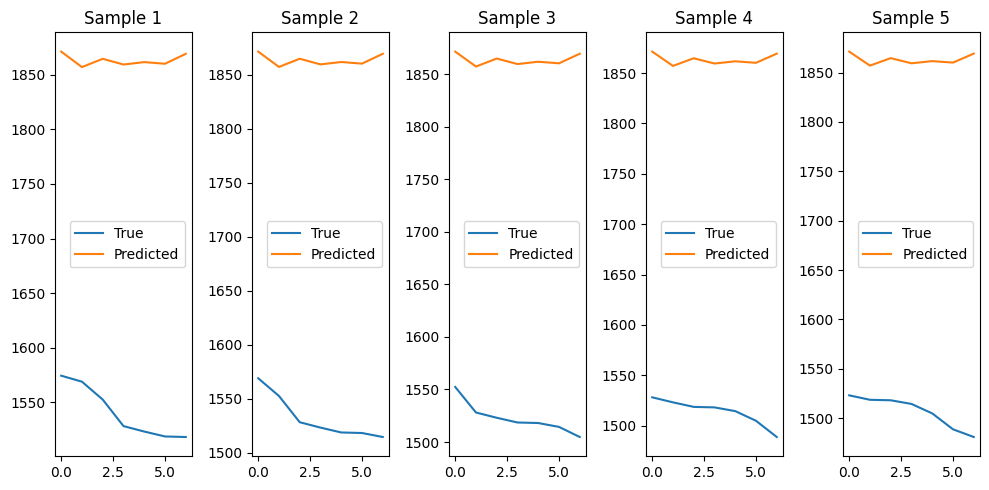

In [11]:
import matplotlib.pyplot as plt

def plot_predictions(model, test_loader):
    model.eval()
    batch_x, batch_y = next(iter(test_loader))
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    predictions = model(batch_x, None, None, None)
    # print(predictions.shape)

    plt.figure(figsize=(10, 5))
    for i in range(min(5, batch_x.size(0))):  # Plot for 5 samples
        plt.subplot(1, 5, i + 1)
        plt.plot(range(batch_y.size(1)), batch_y[i, :, 0].cpu().numpy(), label="True")
        plt.plot(range(predictions.size(1)), predictions[i, :, 0].cpu().detach().numpy(), label="Predicted")
        plt.title(f"Sample {i+1}")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(model, test_loader)

# Train on New Dataset

In [3]:
# Download latest version
path = kagglehub.dataset_download("saketk511/2019-2024-us-stock-market-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HW\.cache\kagglehub\datasets\saketk511\2019-2024-us-stock-market-data\versions\1


In [18]:
df = pd.read_csv(os.path.join(path, "Stock Market Dataset.csv"))
# df.info()
# df.head()


In [19]:
# Convert Gold_Price to numeric and handle missing values
df['Gold_Price'] = pd.to_numeric(df['Gold_Price'].str.replace(',', ''), errors='coerce')
df['Gold_Vol.'] = pd.to_numeric(df['Gold_Vol.'], errors='coerce')
df = df.dropna(subset=['Gold_Price', 'Gold_Vol.'])
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df[['Gold_Price', 'Gold_Vol.']] = min_max_scaler.fit_transform(df[['Gold_Price', 'Gold_Vol.']])


# Hyperparameters
seq_len = 96  # Length of input sequence
horizon = 7   # Predict 1 step ahead
num_samples = len(df) - seq_len - horizon + 1
num_nodes = 1

# Create input-output pairs
inputs = []
targets = []

for i in range(num_samples):
    input_seq = df[['Gold_Price', 'Gold_Vol.']].iloc[i:i + seq_len].values
    target = df['Gold_Price'].iloc[i + seq_len:i + seq_len + horizon].values
    inputs.append(input_seq)
    targets.append(target)

inputs = np.array(inputs)
targets = np.array(targets)

# Define PyTorch Dataset
class GoldPriceDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.inputs = np.repeat(self.inputs[:, :, np.newaxis], num_nodes, axis=2)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.targets = np.repeat(self.targets[:, :, np.newaxis], num_nodes, axis=2)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Split into train and test sets
train_size = int(0.8 * len(inputs))
test_size = len(inputs) - train_size

train_dataset = GoldPriceDataset(inputs[:train_size], targets[:train_size])
test_dataset = GoldPriceDataset(inputs[train_size:], targets[train_size:])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))

# Initialize wandb project
wandb.init(
    project="triformer-gold-price",  # Replace with your project name
    config={
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": train_loader.batch_size,
        "patch_sizes": [2, 4, 12],
        "num_nodes": 1,
        "lag": 96,
        "horizon": 7,
        "channels": 16,
    }
)
config = wandb.config

Train Dataset Size: 911
Test Dataset Size: 228


Epoch,▁▅█
Test Loss,▁
Train Loss,█▁▁
Epoch,3
Test Loss,0.23073
Train Loss,0.01836


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model = Triformer(
    device=device,
    num_nodes=1,
    input_dim=2,
    output_dim=1,  # Predicting only gold price
    channels=16,
    dynamic=True,
    lag=96,
    horizon=7,
    patch_sizes=[2, 4, 12],
    supports=None,
    mem_dim=8
).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            predictions = model(batch_x, None, None, None)  # Pass through the model

            # Compute loss
            loss = criterion(predictions, batch_y)
            epoch_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()
        avg_loss = epoch_loss / len(train_loader)
        wandb.log({"Train Loss": avg_loss, "Epoch": epoch + 1})
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# Testing loop
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x, None, None, None)

            loss = criterion(predictions, batch_y)
            total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        wandb.log({"Test Loss": avg_loss})
    print(f"Test Loss: {total_loss / len(test_loader):.4f}")

# Train and test
train_model(model, train_loader, criterion, optimizer, epochs=3)
test_model(model, test_loader, criterion)


Predicting 7 steps ahead
torch.Size([32, 96, 1, 2])
Epoch 1/3, Loss: 0.0598
Epoch 2/3, Loss: 0.0212
Epoch 3/3, Loss: 0.0215
Test Loss: 0.2790


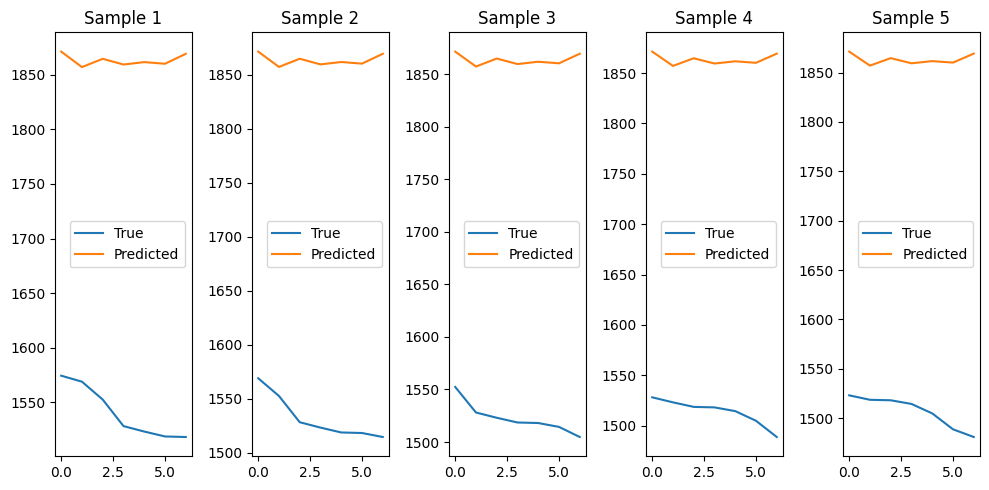

In [12]:
plot_predictions(model, test_loader)

# Assess Performance on Experiment Dataset

In [ ]:
# Read in data
path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Other paths include: 
# https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv,
# https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv, 
# https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv, 
# "https://drive.google.com/uc?export=download&id=1rUPdR7R2iWFW-LMoDdHoO2g4KgnkpFzP",
# "https://drive.google.com/uc?export=download&id=1UBRz-aM_57i_KCC-iaSWoKDPTGGv6EaG"

df = pd.read_csv(path)